In [1]:
from b1 import *
from urllib.request import urlopen
import json
import numpy as np
import pandas as pd
import os
import copy
import math
import statistics
import sklearn.metrics as metrics
 
# Evitar truncar data mostrada al usar jupyter notebook
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
 
# Constante que aloja el diccionario JSON con toda la data
DATA = None

# Obtener data JSON
if os.path.exists('./out/dataout.json'):
    DATA = json.load(open('./out/dataout.json', 'r'))
else:
    data_url = urlopen('http://nutriexcel.cl/UMDU/dataout_v2.json')
    DATA = json.loads(data_url.read())
 
# Labels base de las columnas
LABELS_BASE = {
    # Parámetros del alumno (Target)
    'p1':                            ['p1'],
    'p2':                            ['p2'],
    'np':                            ['np'],
    'p1p2':                          ['p1p2'], # Promedio p1p2 y p2p2
    'p2p2':                          ['p2p2'],
    
    # Parámetros del laboratorio (Features)
    'grade':                         ['g_lab#'],
    'attempts':                      ['a_lab#'],
    'usedtime':                      ['ut_lab#'],
    'activetime':                    ['act_lab#'],
    'disconnections':                ['dis_lab#'],      # log
    'compilationtime':               ['ct_lab#'],
    'runtimedebuggingtime':          ['rt_lab#'],
    'compilationtimeratio':          ['ctr_lab#'],
    'runtimedebuggingtimeratio':     ['rtr_lab#'],
    'errorsreductionratio':          ['err_lab#'],
    'compilationerrorsratio':        ['cer_lab#'],
    'activequartiles':               ['actq1_lab#','actq2_lab#','actq3_lab#'],
    'questionsdifficulty':           ['qd$_lab#'],
    'questionsgrades':               ['qg$_lab#'],      # Promedio
    'questionsattempts':             ['qat$_lab#'],     # Sumar - Max   # log
    'questionsactivetime':           ['qact$_lab#'],    # Promedio
    'questionsavgtime':              ['qavt$_lab#'],    # Promedio
    'questionsmaxerrors':            ['qme$_lab#'],     # Max
    'questionsmaxconsecutiveerrors': ['qmce$_lab#'],    # Max
    'questionsmaxsimilarityratio':   ['qmsr$_lab#'],    # Promedio
    'questionscorrectness':          ['qc$_lab#']       # Promedio
}
 
 
# Cantidad de preguntas por lab
LABS_LENGTHS = {
    '1': 7,
    '2': 6,
    '3': 6,
    '4': 5,
    '5': 3
}

In [2]:
total=0
for id in DATA["courses"]:
    students=len(DATA["courses"][id]["students"])
    total+=students
    print("curso ",id,":",students)
print("total:",total)

curso  7 : 55
curso  13 : 22
curso  19 : 54
curso  24 : 28
curso  30 : 53
curso  36 : 41
total: 253


In [3]:
#@title **Parameters**

# Objective vector
TARGET = 'np'
NORM_TYPE = 'col'
N_FEATURES = 5
 
 
# Import needed libraries ----------------------------------------
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
 
random_state = None # Random state for train_test_split

In [4]:
# CursoData retorna el curso de los alumnos del lab Correspondiente
datalab1_all,cursoData = get_custom_dataframe(DATA, [1], ['np'], 'all', labels=True, index=None)


#cursoData[cursoData.index in datalab1_al]
#print(datalab1_al)


#@title **Data preparation**

datalab1 = copy.deepcopy(datalab1_all)

# Remove questionsdifficulty
remove_col(datalab1, 'qd?')
# Group columns
datalab1 = apply(datalab1, 'dis_lab1', norm_log)
datalab1 = apply(datalab1, 'qg?', statistics.mean)
datalab1 = apply(datalab1, 'qat?', sum, replace=False)
datalab1 = apply(datalab1, 'sum(qat$_lab1)', norm_log, replace=False)
datalab1 = apply(datalab1, 'qat?', max)
datalab1 = apply(datalab1, 'qact?', statistics.mean)
datalab1 = apply(datalab1, 'qavt?', statistics.mean)
datalab1 = apply(datalab1, 'qme?', max)
datalab1 = apply(datalab1, 'qmce?', max)
datalab1 = apply(datalab1, 'qmsr?', statistics.mean)
datalab1 = apply(datalab1, 'qc?', statistics.mean)
aux = datalab1['act_lab1'] / datalab1['sum(qat$_lab1)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab1['avgtime_lab1'] = aux
datalab1 = datalab1.round(4)

7
13
19
24
30
36


In [5]:
# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab1 = pd.concat([datalab1,cursoDF],axis=1)

In [6]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso7 = dfFinlab1.loc[dfFinlab1['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene la columna con el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso7.reset_index()[TARGET])

# Se obtiene los datos del curso X para el lab Y normalizados Excluyendo la fila mean(p$p2)
# ------------               Función que normaliza la data      , el nombre de las col a colocar en el DF  [desde cual columna hasta cual]
DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso7),columns=dfLab1Curso7.columns)[dfLab1Curso7.columns[1:26]]
                       
datalab1Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)
#datalab1Normc7

# Sentencia anterior
#datalab1Normc7 = dfLab1Curso7[['mean(p$p2)']].join(pd.DataFrame(scaler1.fit_transform(dfLab1Curso7), columns=dfLab1Curso7.columns)[dfLab1Curso7.columns[1:26]])

In [7]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso13 = dfFinlab1.loc[dfFinlab1['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso13),columns=dfLab1Curso13.columns)[dfLab1Curso13.columns[1:26]]
                       
datalab1Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)


# Sentencia anterior
#datalab1Normc13 = dfLab1Curso13[['mean(p$p2)']].join(pd.DataFrame(scaler2.fit_transform(dfLab1Curso13), columns=dfLab1Curso13.columns)[dfLab1Curso13.columns[1:26]]) 

In [8]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso19 = dfFinlab1.loc[dfFinlab1['curso']=='19']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso19),columns=dfLab1Curso19.columns)[dfLab1Curso19.columns[1:26]]
                       
datalab1Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)


In [9]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso24 = dfFinlab1.loc[dfFinlab1['curso']=='24']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso24),columns=dfLab1Curso24.columns)[dfLab1Curso24.columns[1:26]]
                       
datalab1Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)

In [10]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso30 = dfFinlab1.loc[dfFinlab1['curso']=='30']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso30),columns=dfLab1Curso30.columns)[dfLab1Curso30.columns[1:26]]
                       
datalab1Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso36 = dfFinlab1.loc[dfFinlab1['curso']=='36']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso36),columns=dfLab1Curso36.columns)[dfLab1Curso36.columns[1:26]]
                       
datalab1Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [12]:
#Se unen los datos del laboratorio 1
datalab1_norm = pd.concat([datalab1Normc7,datalab1Normc13,datalab1Normc19,datalab1Normc24,datalab1Normc30,datalab1Normc36],axis=0)
datalab1_norm = datalab1_norm.reset_index(drop = True)
#datalab1_norm

In [13]:
#LAB 2
datalab2_all,cursoData = get_custom_dataframe(DATA, [2], ['np'], 'all', labels=True, index=None)
 
datalab2 = copy.deepcopy(datalab2_all)
 
# Remove questionsdifficulty
remove_col(datalab2, 'qd?')
# Group columns
datalab2 = apply(datalab2, 'dis_lab2', norm_log)
datalab2 = apply(datalab2, 'qg?', statistics.mean)
datalab2 = apply(datalab2, 'qat?', sum, replace=False)
datalab2 = apply(datalab2, 'sum(qat$_lab2)', norm_log, replace=False)
datalab2 = apply(datalab2, 'qat?', max)
datalab2 = apply(datalab2, 'qact?', statistics.mean)
datalab2 = apply(datalab2, 'qavt?', statistics.mean)
datalab2 = apply(datalab2, 'qme?', max)
datalab2 = apply(datalab2, 'qmce?', max)
datalab2 = apply(datalab2, 'qmsr?', statistics.mean)
datalab2 = apply(datalab2, 'qc?', statistics.mean)
aux = datalab2['act_lab2'] / datalab2['sum(qat$_lab2)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab2['avgtime_lab2'] = aux
datalab2 = datalab2.round(4)

# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab2 = pd.concat([datalab2,cursoDF],axis=1)

7
13
19
24
30
36


In [14]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso7 = dfFinlab2.loc[dfFinlab2['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso7.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso7),columns=dfLab2Curso7.columns)[dfLab2Curso7.columns[1:26]]
                       
datalab2Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)

In [15]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso13 = dfFinlab2.loc[dfFinlab2['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso13),columns=dfLab2Curso13.columns)[dfLab2Curso13.columns[1:26]]
                       
datalab2Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)

In [16]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso19 = dfFinlab2.loc[dfFinlab2['curso']=='19']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso19),columns=dfLab2Curso19.columns)[dfLab2Curso19.columns[1:26]]
                       
datalab2Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)

In [17]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso24 = dfFinlab2.loc[dfFinlab2['curso']=='24']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso24),columns=dfLab2Curso24.columns)[dfLab2Curso24.columns[1:26]]
                       
datalab2Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)

In [18]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso30 = dfFinlab2.loc[dfFinlab2['curso']=='30']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso30),columns=dfLab2Curso30.columns)[dfLab2Curso30.columns[1:26]]
                       
datalab2Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [19]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso36 = dfFinlab2.loc[dfFinlab2['curso']=='36']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso36),columns=dfLab2Curso36.columns)[dfLab2Curso36.columns[1:26]]
                       
datalab2Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [20]:
#Se unen los datos del laboratorio 2
datalab2_norm = pd.concat([datalab2Normc7,datalab2Normc13,datalab2Normc19,datalab2Normc24,datalab2Normc30,datalab2Normc36],axis=0)
datalab2_norm = datalab2_norm.reset_index(drop = True)
#datalab2_norm

In [21]:
#from sklearn.preprocessing import StandardScaler

#scaler1 = StandardScaler()
#datalab2Normc7 = dfLab2Curso7[['mean(p$p2)']].join(pd.DataFrame(scaler1.fit_transform(dfLab2Curso7), columns=dfLab2Curso7.columns)[dfLab2Curso7.columns[1:26]]) 
#datalab2Normc7

In [22]:
#LAB 3

datalab3_all,cursoData = get_custom_dataframe(DATA, [3], ['np'], 'all', labels=True, index=None)

datalab3 = copy.deepcopy(datalab3_all)
 
# Remove questionsdifficulty
remove_col(datalab3, 'qd?')
# Group columns
datalab3 = apply(datalab3, 'dis_lab3', norm_log)
datalab3 = apply(datalab3, 'qg?', statistics.mean)
datalab3 = apply(datalab3, 'qat?', sum, replace=False)
datalab3 = apply(datalab3, 'sum(qat$_lab3)', norm_log, replace=False)
datalab3 = apply(datalab3, 'qat?', max)
datalab3 = apply(datalab3, 'qact?', statistics.mean)
datalab3 = apply(datalab3, 'qavt?', statistics.mean)
datalab3 = apply(datalab3, 'qme?', max)
datalab3 = apply(datalab3, 'qmce?', max)
datalab3 = apply(datalab3, 'qmsr?', statistics.mean)
datalab3 = apply(datalab3, 'qc?', statistics.mean)
aux = datalab3['act_lab3'] / datalab3['sum(qat$_lab3)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab3['avgtime_lab3'] = aux
datalab3 = datalab3.round(4)

for i in range(253):
    #print(datalab3["rt_lab3"]+datalab3["ct_lab3"])
    if datalab3["act_lab3"][i] >0:
        datalab3["ut_lab3"][i]=datalab3["ct_lab3"][i]/(datalab3["act_lab3"][i])
    else:
        datalab3["ut_lab3"][i] = 0.0

#datalab3["ut_lab3"]= datalab3["act_lab3"]-(datalab3["ct_lab3"]+datalab3["rt_lab3"])

# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab3 = pd.concat([datalab3,cursoDF],axis=1)



datalab3

7
13
19
24
30
36


,np,g_lab3,a_lab3,ut_lab3,act_lab3,norm_log(dis_lab3),ct_lab3,rt_lab3,ctr_lab3,rtr_lab3,err_lab3,cer_lab3,actq1_lab3,actq2_lab3,actq3_lab3,max(qat$_lab3),mean(qact$_lab3),mean(qavt$_lab3),max(qme$_lab3),max(qmce$_lab3),mean(qmsr$_lab3),mean(qc$_lab3),sum(qat$_lab3),norm_log(sum(qat$_lab3)),avgtime_lab3
0,5.9,7.0000,1.0,0.108238,3132.0,1.6094,339.0,1754.0,0.1082,0.5600,0.5556,0.4565,0.1562,0.1575,0.1603,22.0,416.5000,61.0667,10.0,6.0,0.5372,0.2428,46.0,3.8501,68.0870
1,5.8,7.0000,1.0,0.020524,8283.0,2.3979,170.0,5640.0,0.0205,0.6809,0.5000,0.1759,0.3750,0.5597,0.8079,38.0,1060.1667,56.8552,2.0,5.0,0.3172,0.2761,108.0,4.6913,76.6944
2,5.7,6.0000,1.0,0.000000,12762.0,3.1355,0.0,5996.0,0.0000,0.4698,0.4884,0.3462,0.5252,0.5321,0.8033,35.0,1499.8333,130.2855,6.0,6.0,0.8407,0.3343,104.0,4.6540,122.7115
3,6.4,7.0000,1.0,0.182678,5923.0,2.3979,1082.0,3270.0,0.1827,0.5521,0.5000,0.4103,0.0643,0.0708,0.0890,32.0,792.6667,70.7674,4.0,12.0,0.5624,0.2977,78.0,4.3694,75.9359
4,4.4,4.0000,1.0,0.210494,3278.0,1.7918,690.0,1097.0,0.2105,0.3347,0.4286,0.6111,0.3577,0.5277,0.5295,19.0,442.3333,60.4722,10.0,10.0,0.4700,0.2314,36.0,3.6109,91.0556
5,5.7,7.0000,1.0,0.099314,2769.0,1.6094,275.0,1381.0,0.0993,0.4987,0.8571,0.2727,0.0678,0.0688,0.0707,7.0,288.0000,115.3334,5.0,3.0,0.8980,0.4000,22.0,3.1355,125.8636
6,5.1,7.0000,1.0,0.209865,2068.0,1.9459,434.0,804.0,0.2099,0.3888,0.7391,0.5676,0.2704,0.2711,0.5904,11.0,236.5000,37.0671,9.0,5.0,0.8206,0.3903,37.0,3.6376,55.8919
7,6.0,7.0000,1.0,0.012650,10514.0,1.7918,133.0,7320.0,0.0126,0.6962,0.4082,0.3925,0.0625,0.0682,0.5270,32.0,1470.6667,70.4256,7.0,14.0,0.6757,0.3685,107.0,4.6821,98.2617
8,7.3,7.0000,1.0,0.039965,3428.0,1.7918,137.0,2586.0,0.0400,0.7544,0.8182,0.2195,0.0619,0.5304,0.5327,15.0,549.6667,61.5629,7.0,2.0,0.3815,0.2424,41.0,3.7377,83.6098
9,6.1,7.0000,1.0,0.052761,12585.0,2.8332,664.0,7598.0,0.0528,0.6037,0.5179,0.3356,0.5310,0.8064,0.9251,53.0,1681.0000,73.5166,10.0,16.0,0.7111,0.2951,149.0,5.0106,84.4631


In [23]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso7 = dfFinlab3.loc[dfFinlab3['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso7.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso7),columns=dfLab3Curso7.columns)[dfLab3Curso7.columns[1:26]]
                       
datalab3Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)

In [24]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso13 = dfFinlab3.loc[dfFinlab3['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso13),columns=dfLab3Curso13.columns)[dfLab3Curso13.columns[1:26]]
                       
datalab3Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)

In [25]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso19 = dfFinlab3.loc[dfFinlab3['curso']=='19']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso19),columns=dfLab3Curso19.columns)[dfLab3Curso19.columns[1:26]]
                       
datalab3Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)

In [26]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso24 = dfFinlab3.loc[dfFinlab3['curso']=='24']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso24),columns=dfLab3Curso24.columns)[dfLab3Curso24.columns[1:26]]
                       
datalab3Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)

In [27]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso30 = dfFinlab3.loc[dfFinlab3['curso']=='30']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso30),columns=dfLab3Curso30.columns)[dfLab3Curso30.columns[1:26]]
                       
datalab3Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [28]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso36 = dfFinlab3.loc[dfFinlab3['curso']=='36']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso36),columns=dfLab3Curso36.columns)[dfLab3Curso36.columns[1:26]]
                       
datalab3Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [29]:
#Se unen los datos del laboratorio 3
datalab3_norm = pd.concat([datalab3Normc7,datalab3Normc13,datalab3Normc19,datalab3Normc24,datalab3Normc30,datalab3Normc36],axis=0)
datalab3_norm = datalab3_norm.reset_index(drop = True)
#datalab3_norm

In [30]:
#LAB 4

datalab4_all,cursoData = get_custom_dataframe(DATA, [4], ['np'], 'all', labels=True, index=None)
datalab4 = copy.deepcopy(datalab4_all)

# Remove questionsdifficulty
remove_col(datalab4, 'qd?')
# Group columns
datalab4 = apply(datalab4, 'dis_lab4', norm_log)
datalab4 = apply(datalab4, 'qg?', statistics.mean)
datalab4 = apply(datalab4, 'qat?', sum, replace=False)
datalab4 = apply(datalab4, 'sum(qat$_lab4)', norm_log, replace=False)
datalab4 = apply(datalab4, 'qat?', max)
datalab4 = apply(datalab4, 'qact?', statistics.mean)
datalab4 = apply(datalab4, 'qavt?', statistics.mean)
datalab4 = apply(datalab4, 'qme?', max)
datalab4 = apply(datalab4, 'qmce?', max)
datalab4 = apply(datalab4, 'qmsr?', statistics.mean)
datalab4 = apply(datalab4, 'qc?', statistics.mean)
aux = datalab4['act_lab4'] / datalab4['sum(qat$_lab4)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab4['avgtime_lab4'] = aux
datalab4 = datalab4.round(4)

for i in range(253):
    #print(datalab3["rt_lab3"]+datalab3["ct_lab3"])
    if datalab4["act_lab4"][i] >0:
        datalab4["ut_lab4"][i]=datalab4["ct_lab4"][i]/(datalab4["act_lab4"][i])
    else:
        datalab4["ut_lab4"][i] = 0.0

# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab4 = pd.concat([datalab4,cursoDF],axis=1)




7
13
19
24
30
36


In [31]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso7 = dfFinlab4.loc[dfFinlab4['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso7.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso7),columns=dfLab4Curso7.columns)[dfLab4Curso7.columns[1:26]]
                       
datalab4Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)
#datalab4Normc7

In [32]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso13 = dfFinlab4.loc[dfFinlab4['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso13),columns=dfLab4Curso13.columns)[dfLab4Curso13.columns[1:26]]
                       
datalab4Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)

In [33]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso19 = dfFinlab4.loc[dfFinlab4['curso']=='19']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso19),columns=dfLab4Curso19.columns)[dfLab4Curso19.columns[1:26]]
                       
datalab4Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)

In [34]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso24 = dfFinlab4.loc[dfFinlab4['curso']=='24']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso24),columns=dfLab4Curso24.columns)[dfLab4Curso24.columns[1:26]]
                       
datalab4Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)


In [35]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso30 = dfFinlab4.loc[dfFinlab4['curso']=='30']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso30),columns=dfLab4Curso30.columns)[dfLab4Curso30.columns[1:26]]
                       
datalab4Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [36]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso36 = dfFinlab4.loc[dfFinlab4['curso']=='36']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso36),columns=dfLab4Curso36.columns)[dfLab4Curso36.columns[1:26]]
                       
datalab4Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [37]:
#Se unen los datos del laboratorio 4
datalab4_norm = pd.concat([datalab4Normc7,datalab4Normc13,datalab4Normc19,datalab4Normc24,datalab4Normc30,datalab4Normc36],axis=0)
datalab4_norm = datalab4_norm.reset_index(drop = True)
#datalab4_norm

In [38]:
#@title **Grid/Random-SearchCV process**   
 
def run_process(dataset, grid_cv, target=TARGET):
    X, y = dataset.drop(target, axis=1), np.array(dataset[target])
   
    grid_cv.fit(X,y)
    print('R2:', max(grid_cv.cv_results_['mean_test_score']))
    
    try:
        selected_features = X.columns[grid_cv.best_estimator_.steps[0][-1].get_support()]
    except:
        return list(dataset.columns[1:])
    
    return list(selected_features)
    
def run_process_obsolete(dataset, grid_cv, target=TARGET):
    X, y = dataset.drop(target, axis=1), np.array(dataset[target])
   
    grid_cv.fit(X,y)
 
    try:
        print('R2-test-fit:', max(grid_cv.cv_results_['mean_test_score']))
    except:
        pass

    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        grid_cv.best_estimator_.fit(X_train, y_train)
        print('R2-test', grid_cv.best_estimator_.score(X_test, y_test))
        print('MSE-test', metrics.mean_squared_error(y_test,grid_cv.best_estimator_.predict(X_test)))

        print('Best params:', grid_cv.best_params_)

        selected_features = X.columns[grid_cv.best_estimator_.steps[0][-1].get_support()]
        print('Selected features:', list(selected_features))

        return list(selected_features)
    except:
        return list(dataset.columns[1:])

In [39]:
#@title **SVR - Recursive Features Elimination**

from sklearn.svm import SVR

sel_estimator = SVR(kernel='linear')
selector = RFE(sel_estimator)
estimator = SVR()

pipe = Pipeline([
    ('sel', selector),
    ('est', estimator)
])

params = {
    'sel__n_features_to_select' : [5],
    'sel__step'                 : [1,2],
    'est__C'                    : [0.01,0.1,1],
    'est__gamma'                : ['scale','auto'],
    'est__kernel'               : ['linear','poly','rbf']
}

grid_svr = GridSearchCV(estimator=pipe,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [40]:
datalab1_shuffle = datalab1_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab1_shuffle = datalab1_shuffle[datalab1_shuffle.np>1]
selected_features_svr_1 = run_process(datalab1_shuffle,grid_svr)
selected_features_svr_1

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   29.6s finished


R2: 0.020640899288381098


['g_lab1', 'cer_lab1', 'actq1_lab1', 'max(qme$_lab1)', 'mean(qmsr$_lab1)']

In [48]:
datalab2_shuffle = datalab2_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab2_shuffle = datalab2_shuffle[datalab2_shuffle.np>1]
selected_features_svr_2 = run_process(datalab2_shuffle,grid_svr)
selected_features_svr_2

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   30.0s finished


R2: 0.11254111977610262


['rt_lab2', 'ctr_lab2', 'err_lab2', 'actq3_lab2', 'norm_log(sum(qat$_lab2))']

In [ ]:
datalab3_shuffle = datalab3_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab3_shuffle = datalab3_shuffle[datalab3_shuffle.np>1]
selected_features_svr_3 = run_process(datalab3_shuffle,grid_svr)
selected_features_svr_3

In [50]:
datalab4_shuffle = datalab4_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab4_shuffle = datalab4_shuffle[datalab4_shuffle.np>1]
selected_features_svr_4 = run_process(datalab4_shuffle,grid_svr)
selected_features_svr_4

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   28.5s finished


R2: 0.05321616870109906


['act_lab4', 'rt_lab4', 'rtr_lab4', 'cer_lab4', 'norm_log(sum(qat$_lab4))']

In [152]:
estimator = SVR()

params = {
    'C'         : [0.01,0.1,1],
    'gamma'     : ['scale','auto'],
    'kernel'    : ['linear','poly','rbf']
}

grid_svr = GridSearchCV(estimator=estimator,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [153]:
dataset = datalab1_norm[[TARGET] + selected_features_svr_1].join(datalab2_norm[selected_features_svr_2])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_svr)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   10.5s


R2: 0.14536524631658831


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.3s finished


['a_lab1',
 'cer_lab1',
 'actq1_lab1',
 'max(qme$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rt_lab2',
 'ctr_lab2',
 'err_lab2',
 'actq3_lab2',
 'norm_log(sum(qat$_lab2))']

In [154]:
dataset = datalab1_norm[[TARGET] + selected_features_svr_1].join(datalab2_norm[selected_features_svr_2]).join(datalab3_norm[selected_features_svr_3])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_svr)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.6s


R2: 0.2583306856030839


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.3s finished


['a_lab1',
 'cer_lab1',
 'actq1_lab1',
 'max(qme$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rt_lab2',
 'ctr_lab2',
 'err_lab2',
 'actq3_lab2',
 'norm_log(sum(qat$_lab2))',
 'ut_lab3',
 'act_lab3',
 'cer_lab3',
 'actq1_lab3',
 'norm_log(sum(qat$_lab3))']

In [155]:
dataset = datalab1_norm[[TARGET] + selected_features_svr_1].join(datalab2_norm[selected_features_svr_2]).join(datalab3_norm[selected_features_svr_3]).join(datalab4_norm[selected_features_svr_4])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_svr)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s


R2: 0.2451168627449464


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.4s finished


['a_lab1',
 'cer_lab1',
 'actq1_lab1',
 'max(qme$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rt_lab2',
 'ctr_lab2',
 'err_lab2',
 'actq3_lab2',
 'norm_log(sum(qat$_lab2))',
 'ut_lab3',
 'act_lab3',
 'cer_lab3',
 'actq1_lab3',
 'norm_log(sum(qat$_lab3))',
 'act_lab4',
 'rt_lab4',
 'rtr_lab4',
 'cer_lab4',
 'norm_log(sum(qat$_lab4))']

In [50]:
#@title **Random Forest Regressor** 

from sklearn.ensemble import  RandomForestRegressor
 
# GradientBoostingRegressor / RandomForestRegressor / SVR(kernel='linear')
sel_estimator = GradientBoostingRegressor(random_state=1)
 
# RFE / SelectFromModel
selector = RFE(sel_estimator)
estimator = RandomForestRegressor(random_state=1, n_jobs=-1)
 
pipe = Pipeline([
    ('sel', selector),
    ('est', estimator)
])
 
params = {
    'sel__estimator__learning_rate': [0.05,0.1,0.2],
    'sel__n_features_to_select'    : [5],
    'est__n_estimators'            : [50,100,200,400],
    'est__criterion'               : ['mse','mae'],
    'est__max_features'            : ['auto','sqrt','log2']
}
 
grid_rfr = GridSearchCV(estimator=pipe,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [41]:
datalab1_shuffle = datalab1_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab1_shuffle = datalab1_shuffle[datalab1_shuffle.np>1]
#selected_features_rfr_1 = run_process(datalab1_shuffle,grid_rfr)
selected_features_rfr_1 = ['rt_lab1', 'actq1_lab1', 'actq3_lab1', 'mean(qmsr$_lab1)', 'norm_log(sum(qat$_lab1))']

In [42]:
datalab2_shuffle = datalab2_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab2_shuffle=datalab2_shuffle[datalab2_shuffle.np>1]
#selected_features_rfr_2 = run_process(datalab2_shuffle,grid_rfr)
selected_features_rfr_2 = ['rtr_lab2', 'mean(qmsr$_lab2)', 'mean(qc$_lab2)', 'norm_log(sum(qat$_lab2))', 'avgtime_lab2']

In [43]:
datalab3_shuffle = datalab3_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab3_shuffle=datalab3_shuffle[datalab3_shuffle.np>1]
#selected_features_rfr_3 = run_process(datalab3_shuffle,grid_rfr)
selected_features_rfr_3 = ['a_lab3', 'cer_lab3', 'actq1_lab3', 'actq3_lab3', 'mean(qmsr$_lab3)']

In [44]:
datalab4_shuffle = datalab4_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab4_shuffle=datalab4_shuffle[datalab4_shuffle.np>1]
#selected_features_rfr_4 = run_process(datalab4_shuffle,grid_rfr)
selected_features_rfr_4 = ['norm_log(dis_lab4)', 'cer_lab4', 'max(qme$_lab4)', 'mean(qmsr$_lab4)', 'avgtime_lab4']

In [41]:
#@title **Random Forest Regressor** 

from sklearn.ensemble import  RandomForestRegressor

estimator = RandomForestRegressor(random_state=1, n_jobs=-1)
 
params = {
    'n_estimators'  : [50,100,200,400],
    'criterion'     : ['mse','mae'],
    'max_features'  : ['auto','sqrt','log2']
}
 
grid_rfr = GridSearchCV(estimator=estimator,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

### Conglomerado usando labs 2 y 3

In [39]:
import b1
import importlib
importlib.reload(b1)
from b1 import *

dataset = datalab3_norm[datalab3_norm.columns.delete([25])].join(datalab4_norm[datalab4_norm.columns.delete([0,25])])
remove_col(dataset, 'a_lab?')
#remove_col(dataset, 'mean(qmsr_lab?)')
for col in dataset.columns:
    if col[-1]=='3':
        dataset = apply(dataset, [col[:-1]+'3',col[:-1]+'4'], np.mean)
    elif col[-2]=='3':
        dataset = apply(dataset, [col[:-2]+'3)',col[:-2]+'4)'], np.mean)
    elif len(col)>3 and col[-3]=='3':
        dataset = apply(dataset, [col[:-3]+'3))',col[:-3]+'4))'], np.mean)
#dataset = apply(dataset, ['act_lab3','act_lab4'], np.mean)
#dataset = apply(dataset, ['norm_log(dis_lab3)','norm_log(dis_lab4)'], np.mean)
#dataset = apply(dataset, ['norm_log(dis_lab3)','norm_log(dis_lab4)'], np.mean)
#dataset = apply(dataset, ['sum(qat$_lab1)','sum(qat$_lab2)','sum(qat$_lab3)','sum(qat$_lab4)'], sum)

In [46]:
#dataset

In [56]:
#Combinación de laboratorios
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
att_rfr=run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min


R2: 0.35089722322742234


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.6min finished


In [57]:
sorted = np.argsort(-grid_rfr.best_estimator_.feature_importances_)
np.array([grid_rfr.best_estimator_.feature_importances_[i] for i in sorted])

array([0.35018119, 0.06182623, 0.05939596, 0.05875793, 0.05319861,
       0.04524287, 0.0430235 , 0.03700796, 0.032324  , 0.03012577,
       0.0260203 , 0.02497318, 0.02177916, 0.01967037, 0.01886096,
       0.01729469, 0.01647722, 0.01645273, 0.01601151, 0.01582879,
       0.01423341, 0.01119204, 0.01012162])

In [58]:
np.array([[att_rfr[i],i,grid_rfr.best_estimator_.feature_importances_[i]] for i in sorted])

array([['mean(g_lab$)', '0', '0.35018119320518093'],
       ['mean(actq3_lab$)', '12', '0.06182622787484934'],
       ['mean(cer_lab$)', '9', '0.05939595974318067'],
       ['mean(mean(qmsr$_lab$))', '18', '0.05875792836383206'],
       ['mean(rtr_lab$)', '7', '0.0531986058331955'],
       ['mean(rt_lab$)', '5', '0.04524286976543962'],
       ['mean(actq2_lab$)', '11', '0.04302350047254769'],
       ['mean(mean(qc$_lab$))', '19', '0.03700796362389611'],
       ['mean(avgtime_lab$)', '22', '0.03232400268239791'],
       ['mean(actq1_lab$)', '10', '0.03012576502941315'],
       ['mean(max(qme$_lab$))', '16', '0.026020301714178917'],
       ['mean(norm_log(dis_lab$))', '3', '0.02497318435017963'],
       ['mean(err_lab$)', '8', '0.02177916316567884'],
       ['mean(max(qat$_lab$))', '13', '0.019670373150539672'],
       ['mean(max(qmce$_lab$))', '17', '0.018860956173758242'],
       ['mean(ctr_lab$)', '6', '0.017294685543180206'],
       ['mean(mean(qavt$_lab$))', '15', '0.016477216680365

In [66]:
X, y = dataset_shuffle.drop(TARGET, axis=1), np.array(dataset_shuffle[TARGET])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=45)
grid_rfr.best_estimator_.fit(X_train,y_train)
y = grid_rfr.best_estimator_.predict(X_test)

print(grid_rfr.best_estimator_.score(X_test,y_test))
#plt.plot([1, 2, 3, 4], [1, 4, 9, 16])


0.26823350413115965


In [67]:
y

array([6.154 , 5.576 , 5.532 , 6.696 , 5.738 , 5.166 , 5.592 , 5.5   ,
       5.766 , 5.466 , 5.838 , 5.796 , 5.584 , 4.2795, 5.5   , 5.772 ,
       6.014 , 5.17  , 3.5615, 6.03  , 5.66  , 5.752 , 5.384 , 6.166 ,
       5.142 , 6.062 , 5.648 , 3.06  , 5.526 , 5.382 , 5.666 , 6.788 ,
       5.624 , 6.092 , 6.408 , 5.94  , 5.666 , 5.426 , 5.688 , 5.83  ,
       5.694 , 5.828 , 5.902 , 5.83  , 5.918 , 5.958 , 3.302 , 6.314 ,
       5.762 , 5.71  , 5.816 , 5.986 , 5.896 , 6.162 , 5.422 , 5.508 ,
       4.1195, 5.64  , 5.444 , 5.296 , 5.88  , 5.714 , 5.566 , 5.496 ,
       5.178 , 5.234 , 5.656 , 5.988 , 5.678 , 5.804 , 5.672 , 5.4   ,
       5.516 , 5.502 , 4.892 , 5.932 , 5.894 , 5.818 ])

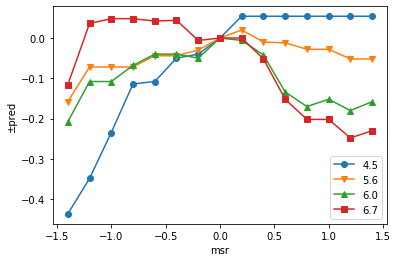

In [61]:
import matplotlib.pyplot as plt
Y = X_test.values.copy()

t = np.arange(-1.4, 1.6, 0.2)
att=18
att_label='msr'
plt.xlabel(att_label) 
plt.ylabel('±pred') 


for i in [[13,'o-'],[2,'v-'],[16,'^-'],[3,'s-']]:
    Y[i[0]][att] = 0
    r=grid_rfr.best_estimator_.predict([Y[i[0]]])
    
    ft = [grid_rfr.best_estimator_.predict([Y[i[0]]])-r for Y[i[0]][att] in t ]
    plt.plot(t,ft, i[1], label=str("%.1f" % r))


plt.legend()

plt.savefig(att_label+'-g.pdf')
plt.show()


In [68]:
x = np.arange(-2.,2.,0.2)
y = np.arange(-2.,2.,0.2)
X,Y = np.meshgrid(x, y) # grid of point
YY = X_test.values.copy()

def z_func(X,Y, n, p1, p2):
    Z = np.zeros((len(X),len(Y)),dtype=np.float64)
    for i in range(len(X)):
        for j in range(len(Y)):
            YY[n][p1]=X[i]
            YY[n][p2]=Y[j]
            Z[i][j]=grid_rfr.best_estimator_.predict([YY[n]])
    return Z

Z = z_func(x, y, 0, 7, 22) # evaluation of the function on the grid

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


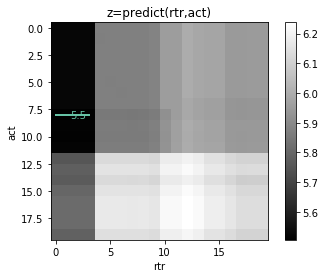

In [69]:


im = plt.imshow(Z,cmap=plt.cm.binary_r) # drawing the function
# adding the Contour lines with labels
cset = plt.contour(Z,np.arange(-2,2,0.2),linewidths=2,cmap=plt.cm.Set2)
plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
plt.colorbar(im) # adding the colobar on the right
# latex fashion title
plt.title('z=predict(rtr,act)')
plt.xlabel('rtr')
plt.ylabel('act')
plt.show()

In [116]:
#Combinación de laboratorios
dataset = datalab1_norm[[TARGET] + selected_features_rfr_1].join(datalab2_norm[selected_features_rfr_2])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.3min finished


R2: 0.22622306211239876


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2']

In [117]:
dataset = datalab1_norm[[TARGET] + selected_features_rfr_1].join(datalab2_norm[selected_features_rfr_2]).join(datalab3_norm[selected_features_rfr_3])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


R2: 0.413248869913123


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2',
 'a_lab3',
 'cer_lab3',
 'actq1_lab3',
 'actq3_lab3',
 'mean(qmsr$_lab3)']

In [118]:
dataset = datalab1_norm[[TARGET] + selected_features_rfr_1].join(datalab2_norm[selected_features_rfr_2]).join(datalab3_norm[selected_features_rfr_3]).join(datalab4_norm[selected_features_rfr_4])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min


R2: 0.45328232812119307


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.5min finished


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2',
 'a_lab3',
 'cer_lab3',
 'actq1_lab3',
 'actq3_lab3',
 'mean(qmsr$_lab3)',
 'norm_log(dis_lab4)',
 'cer_lab4',
 'max(qme$_lab4)',
 'mean(qmsr$_lab4)',
 'avgtime_lab4']

# PLOT

In [119]:
X, y = dataset_shuffle.drop(TARGET, axis=1), np.array(dataset_shuffle[TARGET])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
grid_rfr.best_estimator_.fit(X_train,y_train)
ypred = grid_rfr.best_estimator_.predict(X_test)
grid_rfr.best_estimator_.score(X_test,y_test)

0.4988340093505541

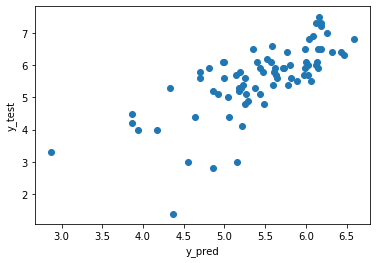

In [120]:
import matplotlib.pyplot as plt
plt.scatter(ypred,y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')
#plt.savefig('pruebas_rf_1234_0.3.png')
plt.show()

In [146]:
grid_rfr.best_estimator_.feature_importances_

array([0.02592353, 0.03787414, 0.02766525, 0.04312142, 0.02046497,
       0.04677065, 0.05709156, 0.03863762, 0.03893699, 0.03634464,
       0.09299988, 0.05971999, 0.06533319, 0.07990229, 0.08313161,
       0.03884615, 0.04649068, 0.02701885, 0.04518106, 0.08854553])

In [53]:
#@title **Linear Regression**

from sklearn.linear_model import LinearRegression
 
# GradientBoostingRegressor / RandomForestRegressor / SVR(kernel='linear')
sel_estimator = GradientBoostingRegressor(random_state=1)
 
# RFE / SelectFromModel
selector = RFE(sel_estimator)
estimator = LinearRegression()

pipe = Pipeline([
    ('sel', selector),
    ('est', estimator)
])
 
# params = {'est__n_jobs': [-1], 
#           'est__normalize': [True], 
#           'sel__estimator__learning_rate': [0.1], 
#           'sel__estimator__n_estimators': [100], 
#           'sel__max_features': [10], 
#           'sel__prefit': [False]}

params = {
    'sel__n_features_to_select' : [5],
    'sel__step'                 : [1,2],
    'est__n_jobs'               : [-1],
}
 
grid_lr = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring='r2',
                       verbose=1,
                       n_jobs=-1,
                       return_train_score=True,
                       cv=KFold(n_splits=10, shuffle=False))

In [53]:
#datalab1_shuffle = datalab1_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_1 = run_process(datalab1_shuffle,grid_lr)
selected_features_lr_1

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.5s finished


R2: -0.059131668073848495


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))']

In [54]:
#datalab2_shuffle = datalab2_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_2 = run_process(datalab2_shuffle,grid_lr)
selected_features_lr_2

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.7s finished


R2: 0.05448532464032642


['rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2']

In [55]:
#datalab3_shuffle = datalab3_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_3 = run_process(datalab3_shuffle,grid_lr)
selected_features_lr_3

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.4s finished


R2: 0.11892293242188863


['a_lab3', 'cer_lab3', 'actq1_lab3', 'actq3_lab3', 'mean(qmsr$_lab3)']

In [52]:
#datalab4_shuffle = datalab4_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_4 = run_process(datalab4_shuffle,grid_lr)
selected_features_lr_4

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.4s finished


R2: -0.10917990369638046


['a_lab4', 'cer_lab4', 'actq1_lab4', 'mean(qmsr$_lab4)', 'avgtime_lab4']

In [51]:
from sklearn.linear_model import LinearRegression
estimator = LinearRegression()
 
params = {
    'n_jobs'    : [-1],
}
 
grid_lr = GridSearchCV(estimator=estimator,
                       param_grid=params,
                       scoring='r2',
                       verbose=1,
                       n_jobs=-1,
                       return_train_score=True,
                       cv=KFold(n_splits=10, shuffle=False))

In [57]:
#Combinación de laboratorios 1 y 2
dataset = datalab1_norm[[TARGET] + selected_features_lr_1].join(datalab2_norm[selected_features_lr_2])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.09100690803255038


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2']

In [58]:
#Combinación de laboratorios 1, 2 y 3
dataset = datalab1_norm[[TARGET] + selected_features_lr_1].join(datalab2_norm[selected_features_lr_2]).join(datalab3_norm[selected_features_lr_3])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.1946749240437255


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2',
 'a_lab3',
 'cer_lab3',
 'actq1_lab3',
 'actq3_lab3',
 'mean(qmsr$_lab3)']

In [59]:
#Combinación de laboratorios 1, 2, 3 y 4
dataset = datalab1_norm[[TARGET] + selected_features_lr_1].join(datalab2_norm[selected_features_lr_2]).join(datalab3_norm[selected_features_lr_3]).join(datalab4_norm[selected_features_lr_4])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.16884636431415478


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2',
 'a_lab3',
 'cer_lab3',
 'actq1_lab3',
 'actq3_lab3',
 'mean(qmsr$_lab3)',
 'a_lab4',
 'cer_lab4',
 'actq1_lab4',
 'mean(qmsr$_lab4)',
 'avgtime_lab4']

In [52]:
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
att=run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.24159351955721112


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


In [53]:
X, y = dataset_shuffle.drop(TARGET, axis=1), np.array(dataset_shuffle[TARGET])
X = X[X.columns.delete(0)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)

grid_lr.best_estimator_.fit(X_train,y_train)
ypred = grid_lr.best_estimator_.predict(X_test)
grid_lr.best_estimator_.score(X_test,y_test)

0.19617688108180897

In [54]:
import statsmodels.api as sm
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     6.076
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           2.30e-13
Time:                        17:32:45   Log-Likelihood:                -287.96
No. Observations:                 234   AIC:                             621.9
Df Residuals:                     211   BIC:                             701.4
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

C:\Users\Dell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


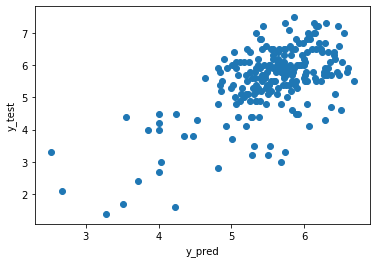

In [73]:
import matplotlib.pyplot as plt
lm = LinearRegression()
lm.fit(X,y)
ypred = lm.predict(X)


plt.scatter(ypred,y)
plt.xlabel('y_pred')
plt.ylabel('y_test')
#plt.savefig('pruebas_rf_1234_0.3.png')
plt.show()

In [43]:
grid_lr.best_estimator_.coef_
grid_lr.best_estimator_.

array([ 0.67661045,  0.03678902, -0.75540105, -0.02401764, -0.08454889,
        1.00974356, -0.00417215, -0.35442981, -0.03158777, -0.36035475,
       -0.09316359,  0.12755456, -0.27081443, -0.24668376, -0.56231946,
        0.05527032,  0.12847526,  0.21034482, -0.0981348 ,  0.00260438,
        0.40993681,  0.18685057,  0.15362998])

In [66]:
sorted = np.argsort(-abs(grid_lr.best_estimator_.coef_))
[grid_lr.best_estimator_.coef_[i] for i in sorted]

[1.0097435609370027,
 -0.75540104946539,
 0.6766104540405308,
 -0.5623194572461464,
 0.4099368136107953,
 -0.3603547474827133,
 -0.3544298127623371,
 -0.27081442725589094,
 -0.246683756573718,
 0.21034482022955228,
 0.18685057121132304,
 0.15362997937896994,
 0.12847525991262887,
 0.12755456313607552,
 -0.09813480314971536,
 -0.09316358640946175,
 -0.0845488945367088,
 0.05527031620246839,
 0.03678902232330016,
 -0.03158777296964665,
 -0.024017636963807973,
 -0.004172153264930725,
 0.0026043821179772757]

In [67]:
[[att[i],grid_lr.best_estimator_.coef_[i]] for i in sorted]

[['mean(rt_lab$)', 1.0097435609370027],
 ['mean(act_lab$)', -0.75540104946539],
 ['mean(g_lab$)', 0.6766104540405308],
 ['mean(mean(qact$_lab$))', -0.5623194572461464],
 ['mean(sum(qat$_lab$))', 0.4099368136107953],
 ['mean(cer_lab$)', -0.3603547474827133],
 ['mean(rtr_lab$)', -0.3544298127623371],
 ['mean(actq$_lab3)', -0.27081442725589094],
 ['mean(max(qat$_lab$))', -0.246683756573718],
 ['mean(max(qmce$_lab$))', 0.21034482022955228],
 ['mean(norm_log(sum(qat$_lab$)))', 0.18685057121132304],
 ['mean(avgtime_lab$)', 0.15362997937896994],
 ['mean(max(qme$_lab$))', 0.12847525991262887],
 ['mean(actq$_lab3)', 0.12755456313607552],
 ['mean(mean(qmsr$_lab$))', -0.09813480314971536],
 ['mean(actq$_lab3)', -0.09316358640946175],
 ['mean(ct_lab$)', -0.0845488945367088],
 ['mean(mean(qavt$_lab$))', 0.05527031620246839],
 ['mean(ut_lab$)', 0.03678902232330016],
 ['mean(err_lab$)', -0.03158777296964665],
 ['mean(norm_log(dis_lab$))', -0.024017636963807973],
 ['mean(ctr_lab$)', -0.004172153264930